In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from saxs_data_processing import io
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import json
from matplotlib.backends.backend_pdf import PdfPages

import sys
sys.path.append('../../silica_opt_insilico/src/silica_opt_insilico/')
import pd_utils
import matplotlib.ticker as ticker

## Load constants and filepaths

In [3]:
with open('../APS/Mesoporous_constants_APS_batch.json', 'rt') as f:
    constants = json.load(f)

In [4]:
data_fp = "/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/APS_Beamtime_Sp25/BatchSamplesData/Reduced_ascii_4_18_25_emptyBlank_renamed"

In [5]:
paths = os.listdir(data_fp)

In [6]:
# load usaxs data

In [7]:
sample_table = pd.read_csv("/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/APS_Beamtime_Sp25/APS_sample_reference_cartridgebatch.csv")

In [8]:
composition_table = pd.read_csv('../APS/Mesoporous_SobolBaseline_APS_BatchMode_3_29_25.csv').set_index('uuid', drop=True)

In [54]:
ctab_mass_to_conc = 0.1
pluronic_mass_to_conc = 0.1

In [9]:
def get_composition(row, teos_dilution_ratio, ctab_concentration, f127_concentration):
    teos_volume = row['teos_volume']
    ammonia_volume = row['ammonia_volume']
    water_volume = row['water_volume']
    ethanol_volume = row['ethanol_volume']
    ctab_volume = row['ctab_volume']
    F127_volume = row['F127_volume']

    total_volume = teos_volume + ammonia_volume + water_volume + ethanol_volume + ctab_volume + F127_volume
    print('Total volume: ', total_volume)
    
    ammonia_vf = ammonia_volume/total_volume
    water_delivered_vf = water_volume / total_volume
    ethanol_delivered_vf = ethanol_volume/total_volume
    ctab_vf = ctab_volume/total_volume
    F127_vf = F127_volume/total_volume


    ## Need to correct for mixed compositions

    # TEOS and ethanol:
    teos_vf = teos_volume/teos_dilution_ratio/total_volume
    teos_etoh_vf = teos_volume*((teos_dilution_ratio - 1)/teos_dilution_ratio)/total_volume

    ethanol_vf = ethanol_delivered_vf + teos_etoh_vf

    print('Ethanol delivered vf: ', ethanol_delivered_vf)
    print('Ethanol TEOS vf: ', teos_etoh_vf)
    print('Total ethanol vf: ', ethanol_vf)

    

    water_vf = water_delivered_vf + F127_vf + ctab_vf

    ctab_mass = ctab_volume * ctab_concentration
    f127_mass = F127_volume * f127_concentration

    # 

    return {'teos_vf':teos_vf, 'ammonia_vf':ammonia_vf, 'water_vf':water_vf, 'ethanol_vf':ethanol_vf, 'ctab_mass':ctab_mass, 'F127_mass':f127_mass}

In [10]:
def get_filename(stub, paths):
    for path in paths:
        if stub in path:
            return path

In [11]:
sobolbatch_samples = {}
teos_dilution_ratio = constants['TEOS']['dilution_ratio']
ctab_concentration = constants['ctab']['stock_concentration_mg_uL']
f127_concentration = constants['f127']['stock_concentration_mg_uL']

for i, row in sample_table.iloc[0:73].iterrows():
    sample = {}
    sample['sample_name'] = row['Sample name']
    sample['cartridge_number'] = row['Cartridge plate']
    sample['cartridge_cell'] = row['Cartridge cell']
    sample_uid = row['Sample ID']

    plate_id = '0_c2' if row['Cartridge plate'] == 2.0 else '1'

    filename_stub = f'{row['Cartridge cell']}_{plate_id}'

    if sample_uid is not np.nan:
        
        filename = get_filename(filename_stub, paths)
        print(filename)
        sample['data'] = pd.read_csv(data_fp+'/'+filename, sep = '\t')


        composition_row = composition_table.loc[sample_uid]
        composition = get_composition(composition_row, teos_dilution_ratio, ctab_concentration, f127_concentration)
        sample['composition'] = composition
        sobolbatch_samples[sample_uid] = sample


        


        
    

2_5dfdbe5e-3f38-44de-b9db-65c72c27f02e_A3_1_2036.dat
Total volume:  9999.999992000001
Ethanol delivered vf:  0.2721331681177065
Ethanol TEOS vf:  0.03215435182396909
Total ethanol vf:  0.3042875199416756
3_93780a39-35f5-4c85-963b-2fde66396c78_A4_1_2037.dat
Total volume:  9999.999992000001
Ethanol delivered vf:  0.2721331681177065
Ethanol TEOS vf:  0.03215435182396909
Total ethanol vf:  0.3042875199416756
4_00afc63f-86d3-41a0-9f37-8d56c6d1abfd_A5_1_2038.dat
Total volume:  9999.999992000001
Ethanol delivered vf:  0.2721331681177065
Ethanol TEOS vf:  0.03215435182396909
Total ethanol vf:  0.3042875199416756
5_83caa81b-c9ac-4b2f-b7b6-97a05c42f277_A6_1_2039.dat
Total volume:  10000.0
Ethanol delivered vf:  0.2101010853994405
Ethanol TEOS vf:  0.053794442619034086
Total ethanol vf:  0.2638955280184746
6_285271f3-055d-4edd-9cdd-3322ed1140ed_A7_1_2040.dat
Total volume:  9999.999999999998
Ethanol delivered vf:  0.1553807337944862
Ethanol TEOS vf:  0.04799717765399256
Total ethanol vf:  0.203377

## Plot scattering

In [12]:
### Plot the one nice one

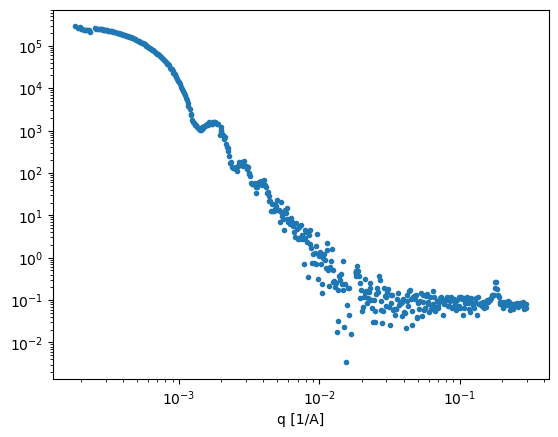

In [13]:
for sample in sobolbatch_samples.values():
    if sample['sample_name'] == 'SobolBatch_43':
        fig, ax = plt.subplots()
        q = sample['data']['Qvector_A']
        I = sample['data']['Intensity']
        ax.loglog(q, I, ls = '', marker = '.')

        ax.set_xlabel('q [1/A]')
        #ax.set_title(sample['sample_name'])
        plt.savefig('sample43.png', dpi = 300)
    

## Make phase plots

In [14]:
# color code by classification
monodisperse_dispersion = [ 18,
                            19,
                            25,
                            27,
                            35,
                            43,
                            62,
]

monodisperse_aggregates = [28
                        ]

polydisperse_dispersion = [
                            'control_1',  
                            'control_2',  
                            'control_3',  
                            4,  
                            12,  
                            15,  
                            16,  
                            20,  
                            22,  
                            24,  
                            'control_4',  
                            31,  
                            33,  
                            37,  
                            41,
]

polydisperse_aggregates = [9,  
                            10,  
                            14,  
                            17,  
                            23,  
                            26,  
                            30,  
                            38,  
                            48,  
                            "control_5",  
                            53,  
                            54,  
                            56,  
                            57,  
                            58,  
                            59,  
                            61
                          ]

other = [
        1,
        2,  
        3,  
        13,  
        29,  
        39,  
        40,  
        42,  
        45,  
        46,  
        47,  
        51,  
        60
]


In [15]:
sample_table.iloc[0:10]

,Sample name,Sample ID,Vial number,Box location,Cartridge plate,Cartridge cell,Loaded?
0,Water blank,NaN,NaN,NaN,1.0,A1,y
1,Empty cell blank,NaN,NaN,NaN,1.0,A2,y
2,SobolBatch_control_1,5dfdbe5e-3f38-44de-b9db-65c72c27f02e,5,A1,1.0,A3,y
3,SobolBatch_control_2,93780a39-35f5-4c85-963b-2fde66396c78,7,A2,1.0,A4,y
4,SobolBatch_control_3,00afc63f-86d3-41a0-9f37-8d56c6d1abfd,9,A3,1.0,A5,y
5,SobolBatch_1,83caa81b-c9ac-4b2f-b7b6-97a05c42f277,10,A4,1.0,A6,y
6,SobolBatch_2,285271f3-055d-4edd-9cdd-3322ed1140ed,11,A5,1.0,A7,y
7,SobolBatch_3,8f86f557-5b97-4a80-b8da-55a55056d4b5,12,A6,1.0,A8,y
8,SobolBatch_4,0491adba-e277-4475-aee0-af111005fd40,24,A7,1.0,B1,y
9,SobolBatch_5,586e06c8-0f02-43a3-9f2f-81e46d43ef64,23,A8,1.0,B2,y


In [16]:
def get_colormap_color_monodispersity(name, monodisperse_dispersion, monodisperse_aggregates, polydisperse_dispersion, polydisperse_aggregates, other):
    if 'control' in name:
        namestub = '_'.join(name.split('_')[1:])
        for entry in monodisperse_dispersion:
            if entry == namestub:
                return 'red'
        for entry in monodisperse_aggregates:
            if entry == namestub:
                return 'red'
        for entry in polydisperse_dispersion:
            if entry == namestub:
                return 'blue'
        for entry in polydisperse_aggregates:
            if entry == namestub:
                return 'blue'
        for entry in other:
            if entry == namestub:
                return 'gray'

    else:
        num = int(name.split('_')[-1])
        for entry in monodisperse_dispersion:
            if eval_match(num, entry):
                return 'red'
        for entry in monodisperse_aggregates:
            if eval_match(num, entry):
                return 'red'
        for entry in polydisperse_dispersion:
            if eval_match(num, entry):
                return 'blue'
        for entry in polydisperse_aggregates:
            if eval_match(num, entry):
                return 'blue'
        for entry in other:
            if eval_match(num, entry):
                return 'gray'
                
    print(name, 'no match found')

def get_colormap_color_aggregates(name, monodisperse_dispersion, monodisperse_aggregates, polydisperse_dispersion, polydisperse_aggregates, other):
    if 'control' in name:
        namestub = '_'.join(name.split('_')[1:])
        for entry in monodisperse_dispersion:
            if entry == namestub:
                return 'orange'
        for entry in monodisperse_aggregates:
            if entry == namestub:
                return 'green'
        for entry in polydisperse_dispersion:
            if entry == namestub:
                return 'orange'
        for entry in polydisperse_aggregates:
            if entry == namestub:
                return 'green'
        for entry in other:
            if entry == namestub:
                return 'gray'

    else:
        num = int(name.split('_')[-1])
        for entry in monodisperse_dispersion:
            if eval_match(num, entry):
                return 'orange'
        for entry in monodisperse_aggregates:
            if eval_match(num, entry):
                return 'green'
        for entry in polydisperse_dispersion:
            if eval_match(num, entry):
                return 'orange'
        for entry in polydisperse_aggregates:
            if eval_match(num, entry):
                return 'green'
        for entry in other:
            if eval_match(num, entry):
                return 'gray'
                
    print('no match found')

def eval_match(num, entry):
    if isinstance(entry, str):
        return False
    elif num == entry:
        return True
    else:
        return False

In [17]:
ctab_min_vf = constants['ctab']['minimum_mass']/constants['ctab']['stock_concentration_mg_uL']/10000
ctab_max_vf = constants['ctab']['maximum_mass']/constants['ctab']['stock_concentration_mg_uL']/10000

In [18]:
f127_min_vf = constants['f127']['minimum_mass']/constants['f127']['stock_concentration_mg_uL']/10000
f127_max_vf = constants['f127']['maximum_mass']/constants['f127']['stock_concentration_mg_uL']/10000

In [40]:
ctab_max_vf

0.6666666666666667

In [55]:
lower_bounds = [constants['TEOS']['minimum_volume_fraction'],
                constants['ammonia']['minimum_volume_fraction'],
                constants['ethanol']['minimum_volume_fraction'],
                constants['ctab']['minimum_mass']*ctab_mass_to_conc,
                constants['f127']['minimum_mass']*pluronic_mass_to_conc,
                constants['water']['minimum_volume_fraction']]

upper_bounds = [constants['TEOS']['maximum_volume_fraction'],
                constants['ammonia']['maximum_volume_fraction'],
                constants['ethanol']['maximum_volume_fraction'],
                constants['ctab']['maximum_mass']*ctab_mass_to_conc,
                constants['f127']['maximum_mass']*pluronic_mass_to_conc,
                constants['water']['maximum_volume_fraction']]

## Calculate volume fraction for CTAB, pluronic

In [56]:
for uuid_val, entry in sobolbatch_samples.items():
    sample = entry['composition']
    sobolbatch_samples[uuid_val]['composition']['ctab_conc'] = sample['ctab_mass']*ctab_mass_to_conc
    sobolbatch_samples[uuid_val]['composition']['F127_conc'] = sample['F127_mass']*pluronic_mass_to_conc

In [57]:
sobolbatch_samples

{'5dfdbe5e-3f38-44de-b9db-65c72c27f02e': {'sample_name': 'SobolBatch_control_1',
  'cartridge_number': 1.0,
  'cartridge_cell': 'A3',
  'data':      Qvector_A     Intensity   Uncertainty
  0     0.000253  32473.332587   1441.400121
  1     0.000262  31848.745324   4478.965097
  2     0.000267  31998.990795   9107.494474
  3     0.000271  31360.587261  11580.730803
  4     0.000276  31667.541185   9066.726254
  ..         ...           ...           ...
  495   0.282079      0.069746      0.002378
  496   0.285966      0.069326      0.002392
  497   0.289885      0.071608      0.002368
  498   0.293837      0.066692      0.002111
  499   0.297823      0.068964      0.001321
  
  [500 rows x 3 columns],
  'composition': {'teos_vf': np.float64(0.017380730715658967),
   'ammonia_vf': np.float64(0.04829034143863227),
   'water_vf': np.float64(0.6300414079040331),
   'ethanol_vf': np.float64(0.3042875199416756),
   'ctab_mass': np.float64(28.60770255),
   'F127_mass': np.float64(102.2299974)

In [58]:
inset_kwargs = {'lw':1}

In [61]:
from matplotlib.ticker import FuncFormatter
def format_func_0(x, _):
    return f'{x:.2f}'

def format_func(x, _):
    return f'{x:.0f}'

SobolBatch_5 no match found
no match found
SobolBatch_6 no match found
no match found
SobolBatch_7 no match found
no match found
SobolBatch_8 no match found
no match found
SobolBatch_11 no match found
no match found
SobolBatch_21 no match found
no match found
SobolBatch_32 no match found
no match found
SobolBatch_34 no match found
no match found
SobolBatch_36 no match found
no match found
SobolBatch_44 no match found
no match found
SobolBatch_49 no match found
no match found
SobolBatch_50 no match found
no match found
SobolBatch_52 no match found
no match found
SobolBatch_55 no match found
no match found
SobolBatch_63 no match found
no match found
<function plot_phasemap.<locals>.<lambda> at 0x7f492c281d00>
<function plot_phasemap.<locals>.<lambda> at 0x7f492c1c4e00>


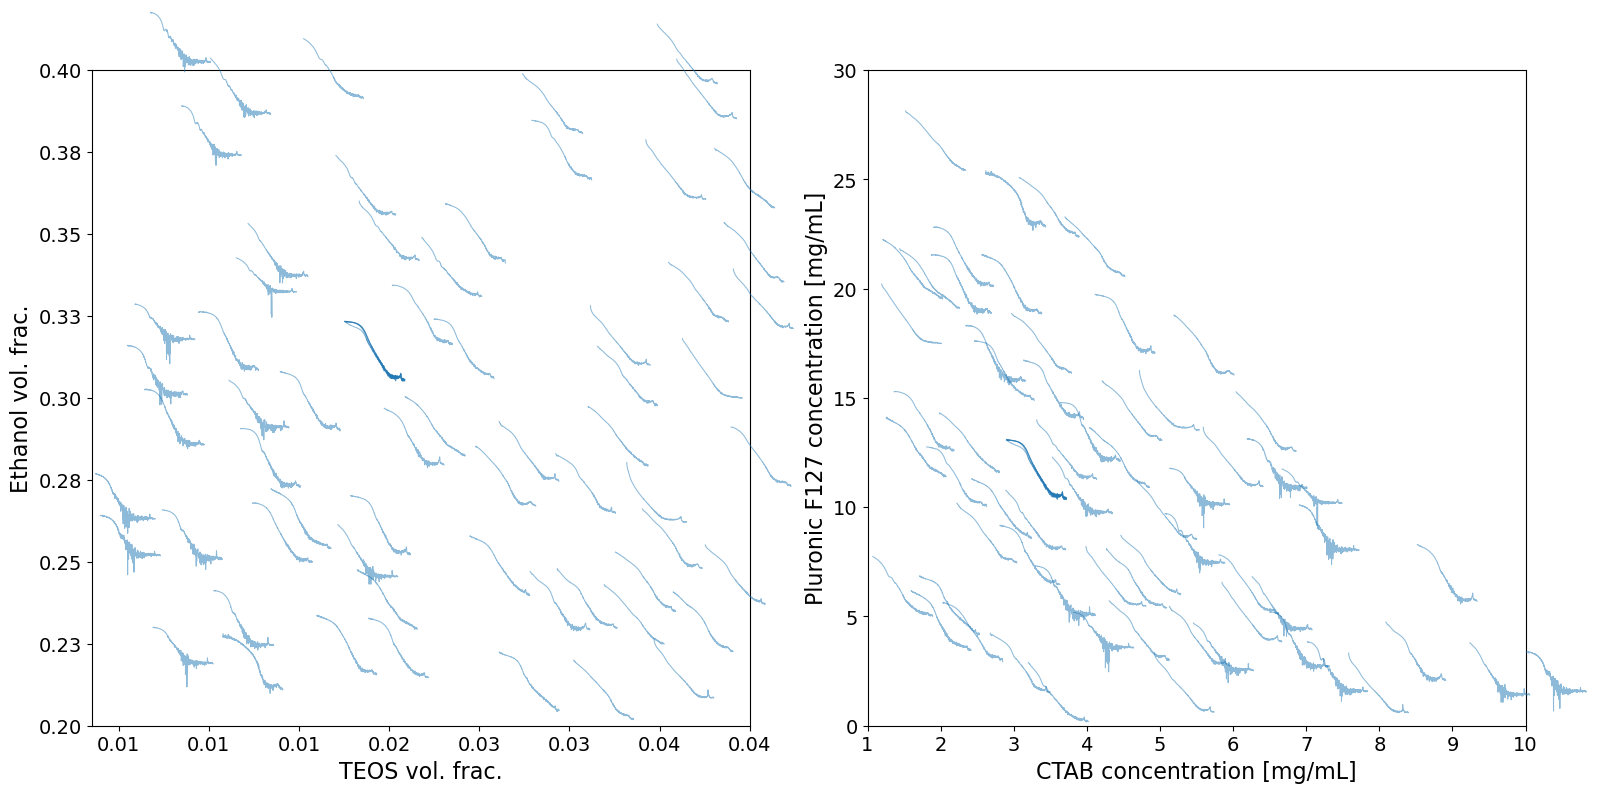

In [62]:
x_ind = 0
y_ind = 2

x_2_ind = 3
y_2_ind = 4


names = ['teos_vf', 'ammonia_vf', 'ethanol_vf', 'ctab_conc', 'F127_conc', 'water_vf']
labels = ['TEOS vol. frac.', 'Ammonium Hyrdroxide vol. frac.', 'Ethanol vol. frac.', 'CTAB concentration [mg/mL]', 'Pluronic F127 concentration [mg/mL]', 'Water vol. frac.']

x_name = names[x_ind]
y_name = names[y_ind]

x_2_name = names[x_2_ind]
y_2_name = names[y_2_ind]

x_min = lower_bounds[x_ind]
x_max = upper_bounds[x_ind]
y_min = lower_bounds[y_ind]
y_max = upper_bounds[y_ind]


x_2_min = lower_bounds[x_2_ind]
x_2_max = upper_bounds[x_2_ind]
y_2_min = lower_bounds[y_2_ind]
y_2_max = upper_bounds[y_2_ind]

bounds = np.array([[x_min, y_min], [x_max, y_max]])
bounds_2 = np.array([[x_2_min, y_2_min], [x_2_max, y_2_max]])

x_key = x_name
y_key = y_name

x_2_key = x_2_name
y_2_key = y_2_name



fig, ax = plt.subplots(1, 2, figsize = (16, 8))

c_1 = []
s = []
c_2 = []

colors_1 = []
colors_2 = []
for uuid_val, sample in sobolbatch_samples.items():

    x_val = sample['composition'][x_key]
    y_val = sample['composition'][y_key]

    x_2_val = sample['composition'][x_2_key]
    y_2_val = sample['composition'][y_2_key]

    I = np.log10(sample['data']['Intensity'])

    c_1.append([x_val, y_val])
    s.append(I)
    c_2.append([x_2_val, y_2_val])
    colors_1.append(get_colormap_color_monodispersity(sample['sample_name'], monodisperse_dispersion, monodisperse_aggregates, polydisperse_dispersion, polydisperse_aggregates, other))
    colors_2.append(get_colormap_color_aggregates(sample['sample_name'], monodisperse_dispersion, monodisperse_aggregates, polydisperse_dispersion, polydisperse_aggregates, other))

        
colors_1 = [color if color == 'red' else 'black' for color in colors_1]
s = np.array(s)

pd_utils.plot_phasemap(bounds, ax[0], c_1, s)#, colors = colors_1)
pd_utils.plot_phasemap(bounds_2, ax[1], c_2, s)#, colors = colors_1)

ax[0].set_xlabel(f'{labels[x_ind]}', size = 16)
ax[0].set_ylabel(f'{labels[y_ind]}', size = 16)
ax[0].yaxis.set_major_formatter(FuncFormatter(format_func_0))
ax[0].xaxis.set_major_formatter(FuncFormatter(format_func_0))

ax[0].set_xlim([bounds[0][0], bounds[1][0]])
ax[0].set_ylim([bounds[0][1], bounds[1][1]])

ax[1].set_xlabel(f'{labels[x_2_ind]}', size = 16)
ax[1].set_ylabel(f'{labels[y_2_ind]}', size = 16)

ax[1].yaxis.set_major_formatter(FuncFormatter(format_func))
ax[1].xaxis.set_major_formatter(FuncFormatter(format_func))

ax[1].set_xlim([bounds_2[0][0], bounds_2[1][0]])
ax[1].set_ylim([bounds_2[0][1], bounds_2[1][1]])

ax[0].tick_params(axis='both', labelsize=14) 
ax[1].tick_params(axis='both', labelsize=14) 


plt.tight_layout()
plt.savefig('USAXS_phaseplots_TEOSEthanolSurfactants.png', dpi = 300)
